## DocLayNet dataset processing & upload to the Hugging Face dataset hub

- **Author**: [Pierre GUILLOU](https://www.linkedin.com/in/pierreguillou/)
- **Date**: 22/01/2023

## Overview

Process the [DocLayNet dataset](https://github.com/DS4SD/DocLayNet) into train/val/test folders and upload a zip file of these folders to the [Hugging Face dataset hub](https://huggingface.co/datasets).

In [ ]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 8.2 MB/s eta 0:00:00


## Setup

In [ ]:
import pathlib
from pathlib import Path
import pickle
import json
import shutil
import numpy as np

## Download

In [ ]:
!mkdir tmp
%cd tmp

/content/tmp


In [ ]:
# download
doclaynet_core = "https://codait-cos-dax.s3.us.cloud-object-storage.appdomain.cloud/dax-doclaynet/1.0.0/DocLayNet_core.zip"
!wget $doclaynet_core

doclaynet_extra = "https://codait-cos-dax.s3.us.cloud-object-storage.appdomain.cloud/dax-doclaynet/1.0.0/DocLayNet_extra.zip"
!wget $doclaynet_extra

--2023-01-23 08:39:15--  https://codait-cos-dax.s3.us.cloud-object-storage.appdomain.cloud/dax-doclaynet/1.0.0/DocLayNet_core.zip
Resolving codait-cos-dax.s3.us.cloud-object-storage.appdomain.cloud (codait-cos-dax.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to codait-cos-dax.s3.us.cloud-object-storage.appdomain.cloud (codait-cos-dax.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30012083650 (28G) [application/zip]
Saving to: ‘DocLayNet_core.zip’

DocLayNet_core.zip  100%[===================>]  27.95G  30.1MB/s    in 14m 50s 

2023-01-23 08:54:06 (32.2 MB/s) - ‘DocLayNet_core.zip’ saved [30012083650/30012083650]

--2023-01-23 08:54:06--  https://codait-cos-dax.s3.us.cloud-object-storage.appdomain.cloud/dax-doclaynet/1.0.0/DocLayNet_extra.zip
Resolving codait-cos-dax.s3.us.cloud-object-storage.appdomain.cloud (codait-cos-dax.s3.us.cloud-object-storage.appdomain.cloud)... 169

In [ ]:
# unzip
%cd ..
!mkdir dataset
!unzip -qq tmp/DocLayNet_core.zip -d dataset/
!unzip -qq tmp/DocLayNet_extra.zip -d dataset/

In [ ]:
!ls -al dataset

total 27164
drwxrwxr-x  7 ubuntu ubuntu    4096 Jan 23 14:59 .
drwxr-xr-x 13 ubuntu ubuntu    4096 Jan 23 14:59 ..
drwx------  2 ubuntu ubuntu    4096 Jul 27 09:27 COCO
drwx------  2 ubuntu ubuntu 9474048 Jul 26 16:32 JSON
drwx------  2 ubuntu ubuntu 9183232 Jul 26 16:33 PDF
drwx------  2 ubuntu ubuntu 9134080 Jul 26 13:42 PNG
drwxrwxr-x  4 ubuntu ubuntu    4096 Jan 23 15:00 __MACOSX


## Dataset preparation

### Paths

In [ ]:
dataset_path = "dataset/"

# existing folders
COCO = dataset_path + "COCO/"
PNG = dataset_path + "PNG/"
JSON = dataset_path + "JSON/"
PDF = dataset_path + "PDF/"

# annotations existing files
train_json = COCO + "train.json"
val_json = COCO + "val.json"
test_json = COCO + "test.json"

# create train/val/test
train_data = dataset_path + "train/"
val_data = dataset_path + "val/"
test_data = dataset_path + "test/"
Path(train_data).mkdir(parents=True, exist_ok=True)
Path(val_data).mkdir(parents=True, exist_ok=True)
Path(test_data).mkdir(parents=True, exist_ok=True)

# create images files by train/val/test
train_images = dataset_path + "train/images/"
val_images = dataset_path + "val/images/"
test_images = dataset_path + "test/images/"
Path(train_images).mkdir(parents=True, exist_ok=True)
Path(val_images).mkdir(parents=True, exist_ok=True)
Path(test_images).mkdir(parents=True, exist_ok=True)

# create pdfs files by train/val/test
train_pdfs = dataset_path + "train/pdfs/"
val_pdfs = dataset_path + "val/pdfs/"
test_pdfs = dataset_path + "test/pdfs/"
Path(train_pdfs).mkdir(parents=True, exist_ok=True)
Path(val_pdfs).mkdir(parents=True, exist_ok=True)
Path(test_pdfs).mkdir(parents=True, exist_ok=True)

# create annotations files by train/val/test
train_annotations = dataset_path + "train/annotations/"
val_annotations = dataset_path + "val/annotations/"
test_annotations = dataset_path + "test/annotations/"
Path(train_annotations).mkdir(parents=True, exist_ok=True)
Path(val_annotations).mkdir(parents=True, exist_ok=True)
Path(test_annotations).mkdir(parents=True, exist_ok=True)

### Images

In [ ]:
json_files = [train_json, val_json, test_json]
images_folders = [train_images, val_images, test_images]

for i,json_file in enumerate(json_files):
    
    with open(json_file) as f:
        dict_json = json.load(f)
        
    for item in dict_json["images"]:
        file_name = item["file_name"]
        src = str(PNG) + file_name
        dest = images_folders[i]
        shutil.copy(src, dest)

In [ ]:
for images_folder in images_folders:
    
    p = Path(images_folder).glob('**/*')
    images = [x for x in p if x.is_file()] #  and x.suffix == ".png"
    print(Path(images_folder).parent.name, len(images))

train 69375
val 6489
test 4999


### PDFs

In [ ]:
json_files = [train_json, val_json, test_json]
pdfs_folders = [train_pdfs, val_pdfs, test_pdfs]

for i,json_file in enumerate(json_files):
    
    with open(json_file) as f:
        dict_json = json.load(f)
        
    for item in dict_json["images"]:
        file_name = item["file_name"]
        pdf_file = file_name.replace(".png", ".pdf")
        src = str(PDF) + pdf_file
        dest = pdfs_folders[i]
        shutil.copy(src, dest)

In [ ]:
for pdfs_folder in pdfs_folders:
    
    p = Path(pdfs_folder).glob('**/*')
    pdfs = [x for x in p if x.is_file()] 
    print(Path(pdfs_folder).parent.name, len(pdfs))

train 69375
val 6489
test 4999


### Annotations

In [ ]:
with open(train_json) as f:
    dict_json = json.load(f) # keys(['categories', 'images', 'annotations'])

id2category = {category["id"]:category["name"] for category in dict_json['categories']}
category2id = {category:id for id,category in id2category.items()}
categories = [id2category[id] for id in range(1, len(id2category)+1)]

len(categories), categories

(11,
 ['Caption',
  'Footnote',
  'Formula',
  'List-item',
  'Page-footer',
  'Page-header',
  'Picture',
  'Section-header',
  'Table',
  'Text',
  'Title'])

In [ ]:
def get_xy(bb):
    """
    Get bounding boxes coordinnates 

    Parameters
    ----------
    bb : list
        [x, y, width, height]
        The (x, y) position is at the top left corner,
        the width is from the x position to the right,
        the height is from the y position to bottom.

    Returns
    -------
    dict
        ['x1', 'x2', 'y1', 'y2']
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner.
    """ 

    x, y, width, height = bb[0], bb[1], bb[2], bb[3]
    x1 = x
    x2 = x1 + width
    y1 = y
    y2 = y1 + height

    bb_dict = dict()
    bb_dict['x1'] = x1
    bb_dict['x2'] = x2
    bb_dict['y1'] = y1
    bb_dict['y2'] = y2

    return bb_dict


# https://github.com/DS4SD/DocLayNet/issues/15
# https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : list
        [x1, y1, width1, height1]
        The (x1, y1) position is at the top left corner,
        the width1 is from the x position to the right,
        the height1 is from the y position to bottom.
    bb2 : list
        [x2, y2, width2, height2]
        The (x2, y2) position is at the top left corner,
        the width2 is from the x position to the right,
        the height2 is from the y position to bottom.

    Returns
    -------
    float
        in [0, 1]
    """

    # convert list to dict ['x1', 'x2', 'y1', 'y2']
    bb1 = get_xy(bb1)
    bb2 = get_xy(bb2)

    # assert bb1['x1'] < bb1['x2']
    # assert bb1['y1'] < bb1['y2']
    # assert bb2['x1'] < bb2['x2']
    # assert bb2['y1'] < bb2['y2']

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    # bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    # iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    iou = intersection_area / float(bb2_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
json_files = [train_json, val_json, test_json]
annotations_files = [train_annotations, val_annotations, test_annotations]

# dict to record image_id of images without annotation
images_wo_annotation = dict()
count_error_iou = dict()
    
for idx_json_file, json_file in enumerate(json_files):
    
    dset_name = Path(json_file).name.replace(".json","")
    print(f"\n>>> {dset_name}\n")
    
    # initialization
    images_wo_annotation[dset_name] = list()
    count_error_iou[dset_name] = list()
    
    with open(json_file) as f:
        dict_json = json.load(f) # keys(['categories', 'images', 'annotations'])

    images = dict_json["images"]
    annotations = dict_json["annotations"]
        
    for num_img, image in enumerate(images):
        
        # image data
        image_id = image["id"]
        file_name = image["file_name"]
        page_hash = file_name.replace(".png", "")
        
        # annotations data of the image
        idx_list, category_id_list, bbox_list, segmentation_list, area_list, iscrowd_list, precedence_list = list(), list(), list(), list(), list(), list(), list()
        for annotation in annotations:
            if annotation["image_id"] == image_id:
                
                idx = annotation["id"]
                category_id = annotation["category_id"]
                bbox = annotation["bbox"]
                segmentation = annotation["segmentation"] # https://github.com/DS4SD/DocLayNet/issues/14
                area = annotation["area"]
                iscrowd = annotation["iscrowd"]
                precedence = annotation["precedence"]

                idx_list.append(idx)
                category_id_list.append(category_id)
                bbox_list.append(bbox)
                segmentation_list.append(segmentation)
                area_list.append(area)
                iscrowd_list.append(iscrowd)
                precedence_list.append(precedence)
                
        # at least one annotation by image
        if len(idx_list) > 0:
            # sort lists
            list1 = idx_list.copy()
            list2 = list(range(len(list1)))
            list1, list2 = (list(t) for t in zip(*sorted(zip(list1, list2))))

            idx_list = np.array(idx_list)[list2].tolist()
            category_id_list = np.array(category_id_list)[list2].tolist()
            bbox_list = np.array(bbox_list)[list2].tolist()
            segmentation_list = np.array(segmentation_list)[list2].tolist()
            area_list = np.array(area_list)[list2].tolist()
            iscrowd_list = np.array(iscrowd_list)[list2].tolist()
            precedence_list = np.array(precedence_list)[list2].tolist()

            # text of the image
            j_file = JSON + page_hash + ".json"
            with open(j_file) as f:
                dict_j_file = json.load(f) # keys(['metadata', 'cells'])

            metadata = dict_j_file['metadata']
            cells = dict_j_file['cells']

            bbox_cell_list, text_cell_list, font_cell_list = list(), list(), list()
            for cell in cells:
                bbox_cell = cell["bbox"]
                text_cell = cell["text"]
                font_cell = cell["font"]

                bbox_cell_list.append(bbox_cell)
                text_cell_list.append(text_cell)
                font_cell_list.append(font_cell)

            # create data
            data = dict()
            data["form"] = list()

            for idx, category_id, bbox, segmentation, area, iscrowd, precedence in zip(idx_list, category_id_list, bbox_list, segmentation_list, area_list, iscrowd_list, precedence_list):

                for idx_bbox_cell, bbox_cell in enumerate(bbox_cell_list):
                    
                    # 95% of the bbox_cell area must be inside the bbox area
                    try:
                        iou = get_iou(bbox, bbox_cell)
                    except:
                        # commun area could not be calculated
                        # for example, the cell area box is null
                        #print(f"- (image_id = {image_id}) The commun area could not be calculated between bbox {bbox} and bbox_cell {bbox_cell}.")
                        count_error_iou[dset_name].append((image_id, idx, bbox, bbox_cell))
                    else:
                        if  iou >= 0.95:

                            data_item = dict()

                            data_item["id_box"] = idx
                            data_item["box"] = bbox # bounding box of the paragraph where is the cell
                            data_item["id_box_line"] = idx_bbox_cell
                            data_item["box_line"] = bbox_cell # bouding box of the cell
                            data_item["text"] = text_cell_list[idx_bbox_cell]
                            data_item["category"] = id2category[category_id]
                            data_item["words"] = list()
                            data_item["linking"] = list()
                            data_item["font"] = font_cell_list[idx_bbox_cell]

                            data["form"].append(data_item)

            # save   
            if bool(data):
                json_image = annotations_files[idx_json_file] + page_hash + ".json"
                with open(json_image, "w") as f:
                    json.dump(data, f)

            if num_img % 1000 == 0: print(f"- number of processed images: {num_img}")
            
        # image without annotation    
        else:
            images_wo_annotation[dset_name].append(image_id)


>>> train

- number of processed images: 0
- number of processed images: 1000
- number of processed images: 2000
- number of processed images: 3000
- number of processed images: 4000
- number of processed images: 5000
- number of processed images: 6000
- number of processed images: 7000
- number of processed images: 8000
- number of processed images: 9000
- number of processed images: 10000
- number of processed images: 11000
- number of processed images: 12000
- number of processed images: 13000
- number of processed images: 14000
- number of processed images: 15000
- number of processed images: 16000
- number of processed images: 17000
- number of processed images: 18000
- number of processed images: 19000
- number of processed images: 20000
- number of processed images: 21000
- number of processed images: 22000
- number of processed images: 23000
- number of processed images: 24000
- number of processed images: 25000
- number of processed images: 26000
- number of processed images:

## Results overview

In [ ]:
dset_names = ["train", "val", "test"]
images_folders = [train_images, val_images, test_images]
pdfs_folders = [train_pdfs, val_pdfs, test_pdfs]
annotations_folders = [train_annotations, val_annotations, test_annotations]

for i,dset_name in enumerate(dset_names):
    print(f"{dset_name}")
    
    # get list of json files with annotations
    p = Path(annotations_folders[i]).glob('**/*')
    json_files = [x for x in p if x.is_file() and x.suffix == ".json"]
    num_json_files = len(json_files)
    
    # get hashes of pages
    pages_hash = [json_file.name.replace(".json", "") for json_file in json_files]
    
    # get list of images files of the json files
    p = Path(images_folders[i]).glob('**/*')
    image_files = [x for x in p if x.is_file() and x.suffix == ".png"]
    num_image_files = len(image_files)
    for image_file in image_files:
        image_hash = image_file.name.replace(".png", "")
        if image_hash not in pages_hash:
            image_file.unlink()
    p = Path(images_folders[i]).glob('**/*')
    image_files = [x for x in p if x.is_file() and x.suffix == ".png"]
    new_num_image_files = len(image_files)
    diff_image = new_num_image_files - num_image_files
        
    # get list of pdfs files of the json files
    p = Path(pdfs_folders[i]).glob('**/*')
    pdf_files = [x for x in p if x.is_file() and x.suffix == ".pdf"]
    num_pdf_files = len(pdf_files)
    for pdf_file in pdf_files:
        pdf_hash = pdf_file.name.replace(".pdf", "")
        if pdf_hash not in pages_hash:
            pdf_file.unlink()
    p = Path(pdfs_folders[i]).glob('**/*')
    pdf_files = [x for x in p if x.is_file() and x.suffix == ".pdf"]
    new_num_pdf_files = len(pdf_files)
    diff_pdf = new_num_pdf_files - num_pdf_files
        
    print(f"- {num_json_files} json files with annotations.")
    if diff_image > 0:
        print(f"- {new_num_image_files} image files with annotations ({diff_image} images deleted because without json file of annotations).")
    else:
        print(f"- {new_num_image_files} image files with annotations.")
    if diff_pdf > 0:
        print(f"- {new_num_pdf_files} pdf files with annotations ({diff_pdf} pdfs deleted because without json file of annotations).")
    else:
        print(f"- {new_num_pdf_files} pdf files with annotations.")
        
    if len(images_wo_annotation[dset_name]) > 0:
        print(f"- {len(images_wo_annotation[dset_name])} images without annotation deleted (and the corresponding json and pdf files, too).")
    if len(count_error_iou[dset_name]) > 0:
        print(f"- {len(count_error_iou[dset_name])} errors de calculation de area commun between bounding boxes of COCO and JSON json files.")

train
- 69103 json files with annotations.
- 69103 image files with annotations.
- 69103 pdf files with annotations.
- 272 images without annotation deleted (and the corresponding json and pdf files, too).
- 13629 errors de calculation de area commun between bounding boxes of COCO and JSON json files.
val
- 6480 json files with annotations.
- 6480 image files with annotations.
- 6480 pdf files with annotations.
- 9 images without annotation deleted (and the corresponding json and pdf files, too).
- 1944 errors de calculation de area commun between bounding boxes of COCO and JSON json files.
test
- 4994 json files with annotations.
- 4994 image files with annotations.
- 4994 pdf files with annotations.
- 5 images without annotation deleted (and the corresponding json and pdf files, too).
- 781 errors de calculation de area commun between bounding boxes of COCO and JSON json files.


## Checking

In [ ]:
def convert_box(boxes):
    token_actual_boxes = list()
    for box in boxes:
        x, y, w, h = tuple(box) # the row comes in (left, top, width, height) format
        token_actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+widght, top+height) to get the actual box 
        token_actual_boxes.append(token_actual_box)
    return token_actual_boxes

def normalize_box(box, width, height):
    return [
        int(1025 * (box[0] / width)),
        int(1025 * (box[1] / height)),
        int(1025 * (box[2] / width)),
        int(1025 * (box[3] / height)),
    ]

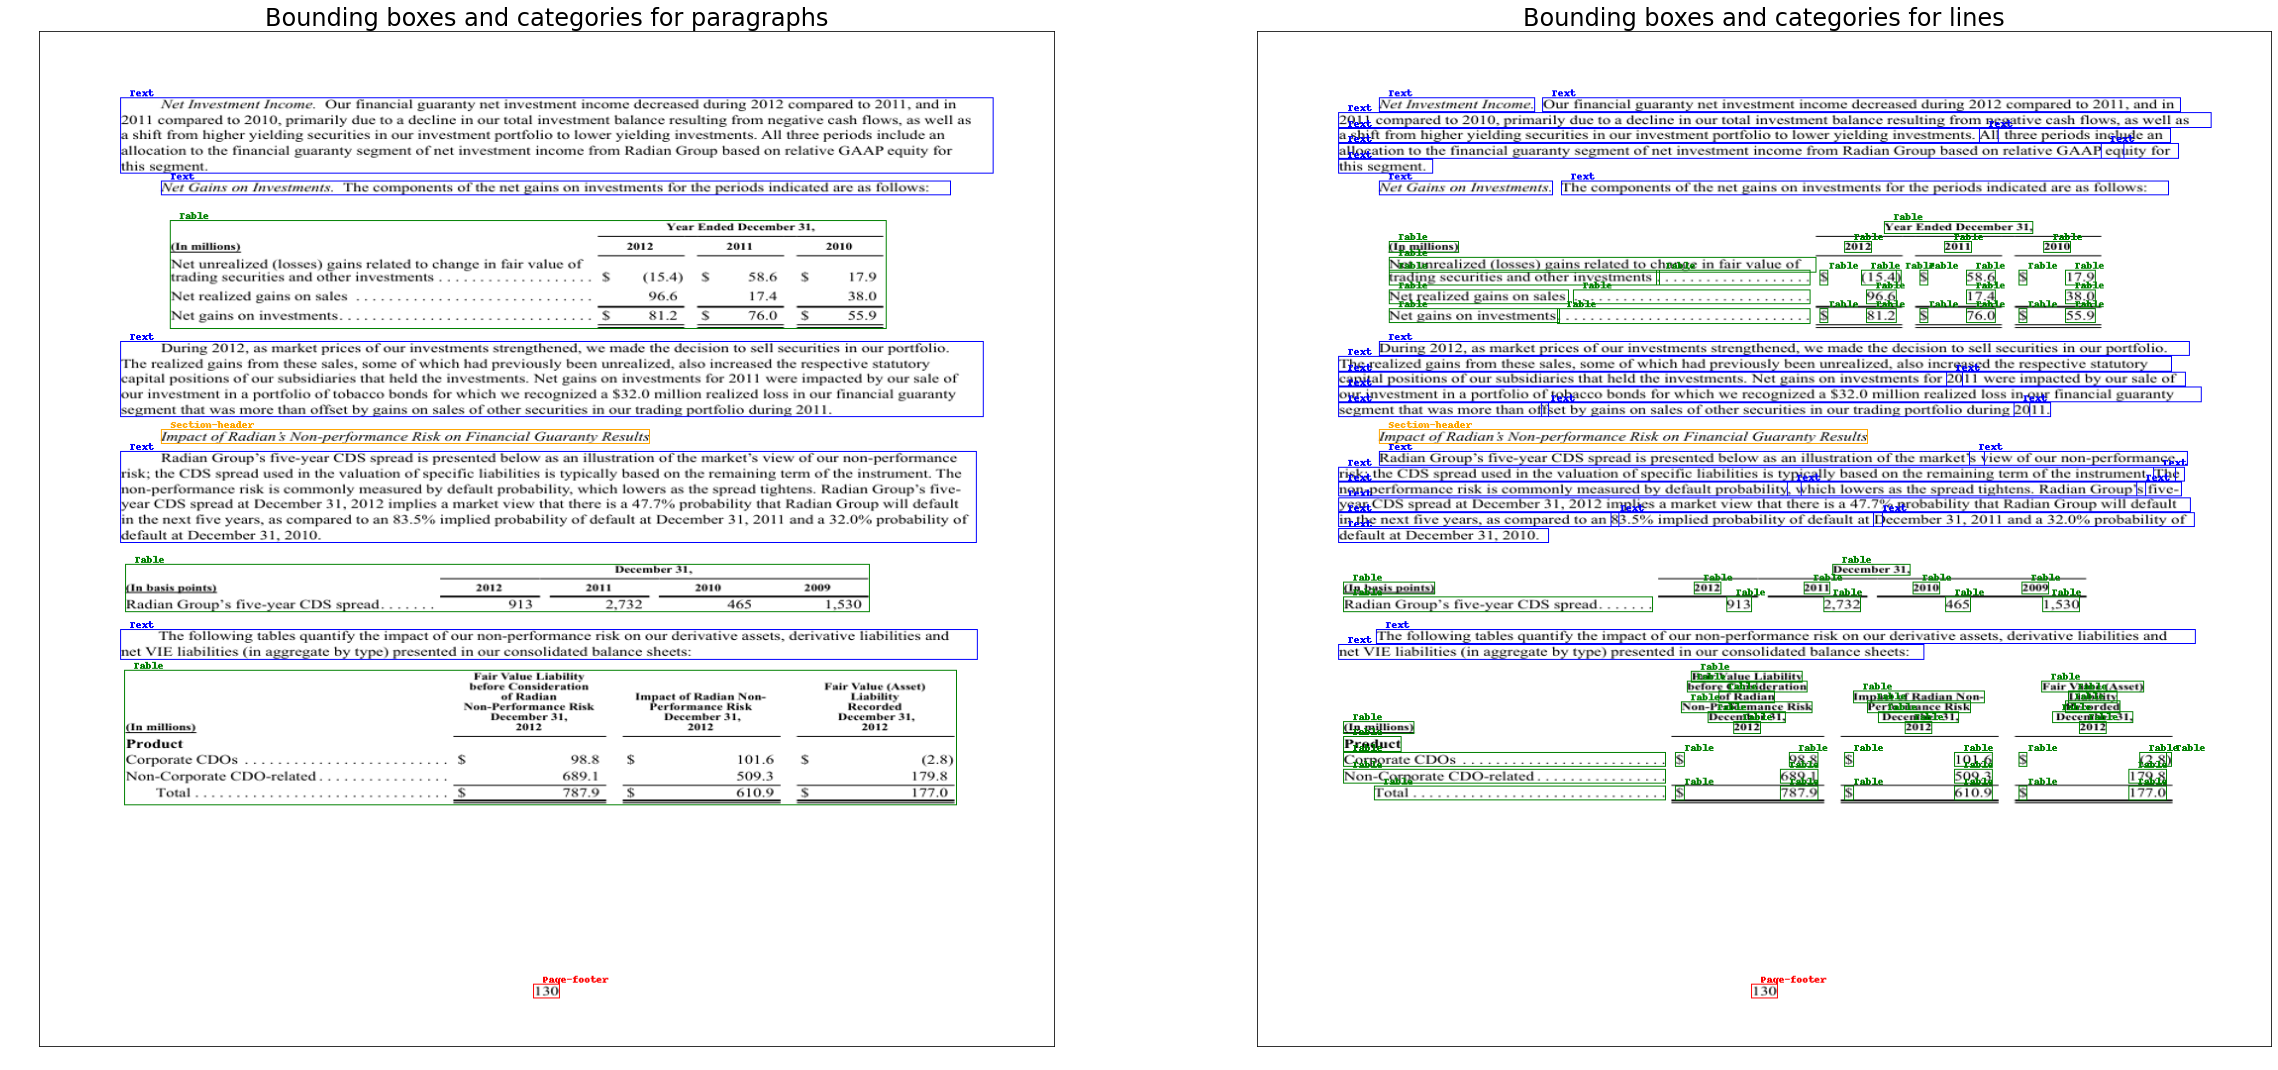

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import random
import matplotlib.pyplot as plt
%matplotlib inline

font = ImageFont.load_default()

# categories colors
cat2color = {'Caption': 'brown',
             'Footnote': 'orange',
             'Formula': 'gray',
             'List-item': 'yellow',
             'Page-footer': 'red',
             'Page-header': 'red',
             'Picture': 'violet',
             'Section-header': 'orange',
             'Table': 'green',
             'Text': 'blue',
             'Title': 'pink'
            }

# get an image
p = Path(train_images).glob('**/*')
image_files = [x for x in p if x.is_file() and x.suffix == ".png"]
index = random.randint(0, len(image_files))
image = image_files[index] # original image
pil_image = Image.open(str(image)).copy()
width, height = pil_image.size

# get corresponding annotation file
page_hash = image.name.replace(".png", "")
json_file = train_annotations + page_hash + '.json'
with open(json_file) as f:
    data = json.load(f) 

# get boxes, texts, categories
boxes, boxes_lines, cats, texts = list(), list(), list(), list()
for data_item in data["form"]:
    boxes.append(data_item["box"])
    boxes_lines.append(data_item["box_line"])
    cats.append(data_item["category"])
    texts.append(data_item["text"])

# convert boxes
actual_boxes = convert_box(boxes)
actual_boxes_lines = convert_box(boxes_lines)
actual_bbox = [actual_boxes, actual_boxes_lines]

# display images
plt.figure(figsize=(40,20), facecolor="w")
columns = 2
images = [pil_image.copy(), pil_image.copy()]
num_imgs = len(images)
for i, img in enumerate(images):
    
    plt.subplot(1, columns, i + 1)
    if i == 0:
        plt.title(f"Bounding boxes and categories for paragraphs", fontsize=24)
    else:
        plt.title(f"Bounding boxes and categories for lines", fontsize=24)
    draw = ImageDraw.Draw(img)
    
    for box, cat, text in zip(actual_bbox[i], cats, texts):
        box = normalize_box(box, width, height)
        draw.rectangle(box, outline=cat2color[cat])
        text = text.encode('latin-1', 'replace').decode('latin-1') # https://stackoverflow.com/questions/56761449/unicodeencodeerror-latin-1-codec-cant-encode-character-u2013-writing-to
        draw.text((box[0] + 10, box[1] - 10), text=cat, fill=cat2color[cat], font=font)
    
    plt.xticks(color="white")
    plt.yticks(color="white")
    plt.tick_params(bottom = False)
    plt.tick_params(left = False)
    #img.resize((int(0.5*width), int(0.5*height)))
    plt.imshow(img)

## Push to HF hub

In [ ]:
%%capture
!pip install datasets huggingface_hub

As Hugging Face has a limite of 50GB by uploaded file, we need to zip our data in 2 or more files (each one with a size < 50GB).

We decide to create 4 zip files of our data.

In [ ]:
num_dsets = [0, 1, 2, 3]

### Paths

In [ ]:
!rm -rf part_dataset_0
!rm -rf part_dataset_1
!rm -rf part_dataset_2
!rm -rf part_dataset_3

### Datasets

In [ ]:
import numpy as np

dset_names = ["train", "val", "test"]

images_folders = [train_images, val_images, test_images]
pdfs_folders = [train_pdfs, val_pdfs, test_pdfs]
annotations_folders = [train_annotations, val_annotations, test_annotations]

json_files_list, image_files_list, pdf_files_list, part_indexes = list(), list(), list(), list()

# get list of indexes and json/image/pdf files
all_total = 0
for i,dset_name in enumerate(dset_names):
    
    print(f"{dset_name}")
    
    # get list of json files with annotations
    p = Path(annotations_folders[i]).glob('**/*')
    json_files = [x for x in p if x.is_file() and x.suffix == ".json"]
    num_json_files = len(json_files)
    
    # Get indexes of 25% of files for each part_dataset
    indexes = list(range(num_json_files))
    part_indexes_0 = indexes[:int(0.25*num_json_files)]
    part_indexes_1 = indexes[int(0.25*num_json_files):int(0.5*num_json_files)]
    part_indexes_2 = indexes[int(0.5*num_json_files):int(0.75*num_json_files)]
    part_indexes_3 = indexes[int(0.75*num_json_files):]
    
    # get list of images files of the json files
    p = Path(images_folders[i]).glob('**/*')
    image_files = [x for x in p if x.is_file() and x.suffix == ".png"]
    num_image_files = len(image_files)
    
    # get list of pdfs files of the json files
    p = Path(pdfs_folders[i]).glob('**/*')
    pdf_files = [x for x in p if x.is_file() and x.suffix == ".pdf"]
    num_pdf_files = len(pdf_files)
    
    part_indexes.append([part_indexes_0, part_indexes_1, part_indexes_2, part_indexes_3])
    json_files_list.append(json_files)
    image_files_list.append(image_files)
    pdf_files_list.append(pdf_files)

    print(f"- part_indexes_0: {len(part_indexes_0)} files")
    print(f"- part_indexes_1: {len(part_indexes_1)} files")
    print(f"- part_indexes_2: {len(part_indexes_2)} files")
    print(f"- part_indexes_3: {len(part_indexes_3)} files")
    total = len(part_indexes_0) + len(part_indexes_1) + len(part_indexes_2) + len(part_indexes_3)
    all_total += total
    print(f"- Total: {total} files")
    
print(f"\nTotal (over the {len(num_dsets)} datasets): {all_total} files")

train
- part_indexes_0: 17275 files
- part_indexes_1: 17276 files
- part_indexes_2: 17276 files
- part_indexes_3: 17276 files
- Total: 69103 files
val
- part_indexes_0: 1620 files
- part_indexes_1: 1620 files
- part_indexes_2: 1620 files
- part_indexes_3: 1620 files
- Total: 6480 files
test
- part_indexes_0: 1248 files
- part_indexes_1: 1249 files
- part_indexes_2: 1248 files
- part_indexes_3: 1249 files
- Total: 4994 files


In [ ]:
# copy files
total_count_files = 0
for num_dset in num_dsets:
    
    part_dataset_path = "part_dataset_" + str(num_dset) + "/"

    # create train/val/test
    part_train_data = part_dataset_path + "train/"
    part_val_data = part_dataset_path + "val/"
    part_test_data = part_dataset_path + "test/"
    Path(part_train_data).mkdir(parents=True, exist_ok=True)
    Path(part_val_data).mkdir(parents=True, exist_ok=True)
    Path(part_test_data).mkdir(parents=True, exist_ok=True)

    # create images files by train/val/test
    part_train_images = part_dataset_path + "train/images/"
    part_val_images = part_dataset_path + "val/images/"
    part_test_images = part_dataset_path + "test/images/"
    Path(part_train_images).mkdir(parents=True, exist_ok=True)
    Path(part_val_images).mkdir(parents=True, exist_ok=True)
    Path(part_test_images).mkdir(parents=True, exist_ok=True)

    # create pdfs files by train/val/test
    part_train_pdfs = part_dataset_path + "train/pdfs/"
    part_val_pdfs = part_dataset_path + "val/pdfs/"
    part_test_pdfs = part_dataset_path + "test/pdfs/"
    Path(part_train_pdfs).mkdir(parents=True, exist_ok=True)
    Path(part_val_pdfs).mkdir(parents=True, exist_ok=True)
    Path(part_test_pdfs).mkdir(parents=True, exist_ok=True)

    # create annotations files by train/val/test
    part_train_annotations = part_dataset_path + "train/annotations/"
    part_val_annotations = part_dataset_path + "val/annotations/"
    part_test_annotations = part_dataset_path + "test/annotations/"
    Path(part_train_annotations).mkdir(parents=True, exist_ok=True)
    Path(part_val_annotations).mkdir(parents=True, exist_ok=True)
    Path(part_test_annotations).mkdir(parents=True, exist_ok=True)
    
    part_images_folders = [part_train_images, part_val_images, part_test_images]
    part_pdfs_folders = [part_train_pdfs, part_val_pdfs, part_test_pdfs]
    part_annotations_folders = [part_train_annotations, part_val_annotations, part_test_annotations]
    
    print(f"\n>>>> Dataset: {part_dataset_path}\n")
    
    count_files = 0
    for i,dset_name in enumerate(dset_names):
        print(f"{dset_name}")

        # get part list of json files
        part_json_files = np.array(json_files_list[i])[part_indexes[i][num_dset]]
        num_part_json_files = len(part_json_files)
        for json_file in part_json_files:
            shutil.copy(json_file, part_annotations_folders[i])

        # get hashes of pages
        part_pages_hash = [json_file.name.replace(".json", "") for json_file in part_json_files]

        # get part list of images files of the json files
        part_image_files = [x for x in image_files_list[i] if x.name.replace(".png", "") in part_pages_hash]
        num_part_image_files = len(part_image_files)
        for image_file in part_image_files:
            shutil.copy(image_file, part_images_folders[i])

        # get part list of pdfs files of the json files
        part_pdf_files = [x for x in pdf_files_list[i] if x.name.replace(".pdf", "") in part_pages_hash]
        num_part_pdf_files = len(part_pdf_files)
        for pdf_file in part_pdf_files:
            shutil.copy(pdf_file, part_pdfs_folders[i])

        print(f"- {num_part_json_files} json files with annotations.")
        print(f"- {num_part_image_files} image files with annotations.")
        print(f"- {num_part_pdf_files} pdf files with annotations.")
        
        count_files += num_part_json_files
        
    print(f"\nTotal: {count_files} files")
    
    total_count_files += count_files
    
print(f"\nTotal (over the {len(num_dsets)} datasets): {total_count_files} files")


>>>> Dataset: part_dataset_0/

train
- 17275 json files with annotations.
- 17275 image files with annotations.
- 17275 pdf files with annotations.
val
- 1620 json files with annotations.
- 1620 image files with annotations.
- 1620 pdf files with annotations.
test
- 1248 json files with annotations.
- 1248 image files with annotations.
- 1248 pdf files with annotations.

Total: 20143 files

>>>> Dataset: part_dataset_1/

train
- 17276 json files with annotations.
- 17276 image files with annotations.
- 17276 pdf files with annotations.
val
- 1620 json files with annotations.
- 1620 image files with annotations.
- 1620 pdf files with annotations.
test
- 1249 json files with annotations.
- 1249 image files with annotations.
- 1249 pdf files with annotations.

Total: 20145 files

>>>> Dataset: part_dataset_2/

train
- 17276 json files with annotations.
- 17276 image files with annotations.
- 17276 pdf files with annotations.
val
- 1620 json files with annotations.
- 1620 image files with

In [ ]:
# zip folders part dataset
for num_dset in num_dsets:
    part_dataset_path = "part_dataset_" + str(num_dset)
    file_zip = part_dataset_path + ".zip"
    !zip -qr $file_zip $part_dataset_path
    
    print(f"- zip of dataset {part_dataset_path} done")

In [ ]:
from huggingface_hub import login
login()

In [ ]:
from huggingface_hub import create_repo

repo_id = "pierreguillou/DocLayNet"
create_repo(repo_id, repo_type="dataset", private=True)

'https://huggingface.co/datasets/pierreguillou/DocLayNet'

In [ ]:
from huggingface_hub import HfApi
api = HfApi()

for num_dset in num_dsets:
    part_dataset_path = "part_dataset_" + str(num_dset)
    file_zip = part_dataset_path + ".zip"
    
    path_or_fileobj = file_zip
    path_in_repo = "data/" + file_zip
    api.upload_file(
        path_or_fileobj=path_or_fileobj,
        path_in_repo=path_in_repo,
        repo_id=repo_id,
        repo_type="dataset",
    )
    
    print(f"dataset {part_dataset_path} uploaded to HF hub at https://huggingface.co/datasets/{repo_id}/data/")

## DocLayNet small

Creating a DocLayNet small with a size of 1% of DocLayNet (random selection).

In [ ]:
pct = 0.01

### Paths

In [ ]:
small_dataset_path = "small_dataset/"

# create train/val/test
small_train_data = small_dataset_path + "train/"
small_val_data = small_dataset_path + "val/"
small_test_data = small_dataset_path + "test/"
Path(small_train_data).mkdir(parents=True, exist_ok=True)
Path(small_val_data).mkdir(parents=True, exist_ok=True)
Path(small_test_data).mkdir(parents=True, exist_ok=True)

# create images files by train/val/test
small_train_images = small_dataset_path + "train/images/"
small_val_images = small_dataset_path + "val/images/"
small_test_images = small_dataset_path + "test/images/"
Path(small_train_images).mkdir(parents=True, exist_ok=True)
Path(small_val_images).mkdir(parents=True, exist_ok=True)
Path(small_test_images).mkdir(parents=True, exist_ok=True)

# create pdfs files by train/val/test
small_train_pdfs = small_dataset_path + "train/pdfs/"
small_val_pdfs = small_dataset_path + "val/pdfs/"
small_test_pdfs = small_dataset_path + "test/pdfs/"
Path(small_train_pdfs).mkdir(parents=True, exist_ok=True)
Path(small_val_pdfs).mkdir(parents=True, exist_ok=True)
Path(small_test_pdfs).mkdir(parents=True, exist_ok=True)

# create annotations files by train/val/test
small_train_annotations = small_dataset_path + "train/annotations/"
small_val_annotations = small_dataset_path + "val/annotations/"
small_test_annotations = small_dataset_path + "test/annotations/"
Path(small_train_annotations).mkdir(parents=True, exist_ok=True)
Path(small_val_annotations).mkdir(parents=True, exist_ok=True)
Path(small_test_annotations).mkdir(parents=True, exist_ok=True)

### Dataset

In [ ]:
import random
import numpy as np
random.seed(0)

dset_names = ["train", "val", "test"]

images_folders = [train_images, val_images, test_images]
pdfs_folders = [train_pdfs, val_pdfs, test_pdfs]
annotations_folders = [train_annotations, val_annotations, test_annotations]

small_data_folders = [small_train_data, small_val_data, small_test_data]
small_images_folders = [small_train_images, small_val_images, small_test_images]
small_pdfs_folders = [small_train_pdfs, small_val_pdfs, small_test_pdfs]
small_annotations_folders = [small_train_annotations, small_val_annotations, small_test_annotations]

for i,dset_name in enumerate(dset_names):
    print(f"{dset_name} ({small_data_folders[i]})")
    
    # get list of json files with annotations
    p = Path(annotations_folders[i]).glob('**/*')
    json_files = [x for x in p if x.is_file() and x.suffix == ".json"]
    num_json_files = len(json_files)
    
    # Get random indexes of 1% of files
    indexes = list(range(num_json_files))
    random.shuffle(indexes)
    small_indexes = indexes[:int(pct*num_json_files)]
    
    # get tiny list of json files
    small_json_files = np.array(json_files)[small_indexes]
    num_small_json_files = len(small_json_files)
    for json_file in small_json_files:
        shutil.copy(json_file, small_annotations_folders[i])
    
    # get hashes of pages
    small_pages_hash = [json_file.name.replace(".json", "") for json_file in small_json_files]
    
    # get tiny list of images files of the json files
    p = Path(images_folders[i]).glob('**/*')
    small_image_files = [x for x in p if x.is_file() and x.suffix == ".png" and x.name.replace(".png", "") in small_pages_hash]
    num_small_image_files = len(small_image_files)
    for image_file in small_image_files:
        shutil.copy(image_file, small_images_folders[i])
        
    # get tiny list of pdfs files of the json files
    p = Path(pdfs_folders[i]).glob('**/*')
    small_pdf_files = [x for x in p if x.is_file() and x.suffix == ".pdf" and x.name.replace(".pdf", "") in small_pages_hash]
    num_small_pdf_files = len(small_pdf_files)
    for pdf_file in small_pdf_files:
        shutil.copy(pdf_file, small_pdfs_folders[i])
        
    print(f"- {num_small_json_files} json files with annotations.")
    print(f"- {num_small_image_files} image files with annotations.")
    print(f"- {num_small_pdf_files} pdf files with annotations.")

train (small_dataset/train/)
- 691 json files with annotations.
- 691 image files with annotations.
- 691 pdf files with annotations.
val (small_dataset/val/)
- 64 json files with annotations.
- 64 image files with annotations.
- 64 pdf files with annotations.
test (small_dataset/test/)
- 49 json files with annotations.
- 49 image files with annotations.
- 49 pdf files with annotations.


### Push to HF hub

In [ ]:
%%capture
!pip install datasets huggingface_hub

In [ ]:
# zip 
dataset_small_zip = "dataset_small.zip"
!zip -qr $dataset_small_zip $small_dataset_path

print(f"zip of dataset {small_dataset_path} done")

- zip of dataset small_dataset/ done


In [ ]:
from huggingface_hub import login
login()

In [ ]:
from huggingface_hub import create_repo

repo_id = "pierreguillou/DocLayNet-small"
create_repo(repo_id, repo_type="dataset", private=True)

'https://huggingface.co/datasets/pierreguillou/DocLayNet-small'

In [ ]:
from huggingface_hub import HfApi
api = HfApi()

path_or_fileobj = dataset_small_zip
path_in_repo = "data/" + dataset_small_zip
api.upload_file(
    path_or_fileobj=path_or_fileobj,
    path_in_repo=path_in_repo,
    repo_id=repo_id,
    repo_type="dataset",
)

print(f"dataset {small_dataset_path} uploaded to HF hub at https://huggingface.co/datasets/{repo_id}/data/")

'https://huggingface.co/datasets/pierreguillou/DocLayNet-small/blob/main/data/dataset_small.zip'

## DocLayNet base

Creating a DocLayNet small with a size of 10% of DocLayNet (random selection).

In [ ]:
pct = 0.1

### Paths

In [ ]:
base_dataset_path = "base_dataset/"

# create train/val/test
base_train_data = base_dataset_path + "train/"
base_val_data = base_dataset_path + "val/"
base_test_data = base_dataset_path + "test/"
Path(base_train_data).mkdir(parents=True, exist_ok=True)
Path(base_val_data).mkdir(parents=True, exist_ok=True)
Path(base_test_data).mkdir(parents=True, exist_ok=True)

# create images files by train/val/test
base_train_images = base_dataset_path + "train/images/"
base_val_images = base_dataset_path + "val/images/"
base_test_images = base_dataset_path + "test/images/"
Path(base_train_images).mkdir(parents=True, exist_ok=True)
Path(base_val_images).mkdir(parents=True, exist_ok=True)
Path(base_test_images).mkdir(parents=True, exist_ok=True)

# create pdfs files by train/val/test
base_train_pdfs = base_dataset_path + "train/pdfs/"
base_val_pdfs = base_dataset_path + "val/pdfs/"
base_test_pdfs = base_dataset_path + "test/pdfs/"
Path(base_train_pdfs).mkdir(parents=True, exist_ok=True)
Path(base_val_pdfs).mkdir(parents=True, exist_ok=True)
Path(base_test_pdfs).mkdir(parents=True, exist_ok=True)

# create annotations files by train/val/test
base_train_annotations = base_dataset_path + "train/annotations/"
base_val_annotations = base_dataset_path + "val/annotations/"
base_test_annotations = base_dataset_path + "test/annotations/"
Path(base_train_annotations).mkdir(parents=True, exist_ok=True)
Path(base_val_annotations).mkdir(parents=True, exist_ok=True)
Path(base_test_annotations).mkdir(parents=True, exist_ok=True)

### Dataset

In [ ]:
import random
import numpy as np
random.seed(0)

dset_names = ["train", "val", "test"]

images_folders = [train_images, val_images, test_images]
pdfs_folders = [train_pdfs, val_pdfs, test_pdfs]
annotations_folders = [train_annotations, val_annotations, test_annotations]

base_data_folders = [base_train_data, base_val_data, base_test_data]
base_images_folders = [base_train_images, base_val_images, base_test_images]
base_pdfs_folders = [base_train_pdfs, base_val_pdfs, base_test_pdfs]
base_annotations_folders = [base_train_annotations, base_val_annotations, base_test_annotations]

for i,dset_name in enumerate(dset_names):
    print(f"{dset_name} ({base_data_folders[i]})")
    
    # get list of json files with annotations
    p = Path(annotations_folders[i]).glob('**/*')
    json_files = [x for x in p if x.is_file() and x.suffix == ".json"]
    num_json_files = len(json_files)
    
    # Get random indexes of 1% of files
    indexes = list(range(num_json_files))
    random.shuffle(indexes)
    base_indexes = indexes[:int(pct*num_json_files)]
    
    # get tiny list of json files
    base_json_files = np.array(json_files)[base_indexes]
    num_base_json_files = len(base_json_files)
    for json_file in base_json_files:
        shutil.copy(json_file, base_annotations_folders[i])
    
    # get hashes of pages
    base_pages_hash = [json_file.name.replace(".json", "") for json_file in base_json_files]
    
    # get tiny list of images files of the json files
    p = Path(images_folders[i]).glob('**/*')
    base_image_files = [x for x in p if x.is_file() and x.suffix == ".png" and x.name.replace(".png", "") in base_pages_hash]
    num_base_image_files = len(base_image_files)
    for image_file in base_image_files:
        shutil.copy(image_file, base_images_folders[i])
        
    # get tiny list of pdfs files of the json files
    p = Path(pdfs_folders[i]).glob('**/*')
    base_pdf_files = [x for x in p if x.is_file() and x.suffix == ".pdf" and x.name.replace(".pdf", "") in base_pages_hash]
    num_base_pdf_files = len(base_pdf_files)
    for pdf_file in base_pdf_files:
        shutil.copy(pdf_file, base_pdfs_folders[i])
        
    print(f"- {num_base_json_files} json files with annotations.")
    print(f"- {num_base_image_files} image files with annotations.")
    print(f"- {num_base_pdf_files} pdf files with annotations.")

train (base_dataset/train/)
- 6910 json files with annotations.
- 6910 image files with annotations.
- 6910 pdf files with annotations.
val (base_dataset/val/)
- 648 json files with annotations.
- 648 image files with annotations.
- 648 pdf files with annotations.
test (base_dataset/test/)
- 499 json files with annotations.
- 499 image files with annotations.
- 499 pdf files with annotations.


### Push to HF hub

In [ ]:
%%capture
!pip install datasets huggingface_hub

In [ ]:
# zip 
dataset_base_zip = "dataset_base.zip"
!zip -qr $dataset_base_zip $base_dataset_path

print(f"zip of dataset {base_dataset_path} done")

zip of dataset base_dataset/ done


In [ ]:
from huggingface_hub import login
login()

In [ ]:
from huggingface_hub import create_repo

repo_id = "pierreguillou/DocLayNet-base"
create_repo(repo_id, repo_type="dataset", private=True)

'https://huggingface.co/datasets/pierreguillou/DocLayNet-base'

In [ ]:
from huggingface_hub import HfApi
api = HfApi()

path_or_fileobj = dataset_base_zip
path_in_repo = "data/" + dataset_base_zip
api.upload_file(
    path_or_fileobj=path_or_fileobj,
    path_in_repo=path_in_repo,
    repo_id=repo_id,
    repo_type="dataset",
)

print(f"dataset {base_dataset_path} uploaded to HF hub at https://huggingface.co/datasets/{repo_id}/data/")

dataset base_dataset/ uploaded to HF hub at https://huggingface.co/datasets/pierreguillou/DocLayNet-base/data/


# END